In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 1024
IMG_HEIGHT = 768
IMG_CHANNELS = 1
TRAIN_PATH = 'data/train/x/'
TRAIN_MASK_PATH = 'data/train/y/'

TEST_PATH = 'data/test/x/'
TEST_MASK_PATH = 'data/test/y/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [3]:
train_ids = next(os.walk(TRAIN_PATH))[2]
train_mask_ids = next(os.walk(TRAIN_MASK_PATH))[2]

test_ids = next(os.walk(TEST_PATH))[2]
test_mask_ids = next(os.walk(TEST_MASK_PATH))[2]

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(next(os.walk(TRAIN_PATH))[2]), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(next(os.walk(TRAIN_MASK_PATH))[2]), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Getting and resizing train images... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH + id_)
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    X_train[n] = img

print('Getting and resizing train masks... ')
for n, id_ in tqdm(enumerate(train_mask_ids), total=len(train_mask_ids)):
    mask = imread(TRAIN_MASK_PATH + id_)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    Y_train[n] = mask


Getting and resizing train images... 


100%|██████████| 165/165 [00:08<00:00, 18.29it/s]


Getting and resizing train masks... 


100%|██████████| 165/165 [00:08<00:00, 19.72it/s]


In [5]:
# Get and resize test images and masks
X_test = np.zeros((len(next(os.walk(TEST_PATH))[2]), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(next(os.walk(TEST_MASK_PATH))[2]), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

print('Getting and resizing test images... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH + id_)
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    X_train[n] = img

print('Getting and resizing test masks... ')
for n, id_ in tqdm(enumerate(test_mask_ids), total=len(test_mask_ids)):
    mask = imread(TEST_MASK_PATH + id_)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
    Y_train[n] = mask


Getting and resizing test images... 


100%|██████████| 165/165 [00:08<00:00, 19.94it/s]


Getting and resizing test masks... 


100%|██████████| 165/165 [00:08<00:00, 20.35it/s]


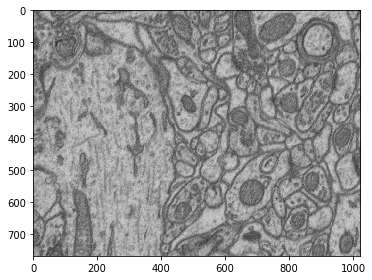

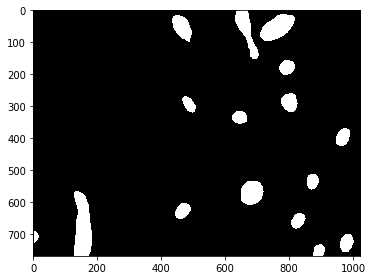

In [15]:
# Check if training data looks all right
ix = random.randint(0, len(next(os.walk(TRAIN_PATH))[2] )-1)
imshow(X_train[ix,:,:,0])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [16]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [17]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 768, 1024, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768, 1024, 1) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 1024, 16 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 768, 1024, 16 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 768, 1024, 16 4624        concatenate_4[0][0]              
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 768, 1024, 16 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 768, 1024, 16 2320        dropout_9[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 768, 1024, 1) 17          conv2d_18[0][0]                  
Total params: 1,940,817
Trainable params: 1,940,817
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 148 samples, validate on 17 samples
Epoch 1/50
